<a href="https://colab.research.google.com/github/JCaballerot/Recommender_Systems/blob/main/K_Nearest_Neighbors_Recommender/MovieLens_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<h1 align=center><font size = 5> Collaborative Filtering con KNN en MovieLens: Item - Item</font></h1>

---

**Índice**

- 1. Introducción
- 2. Configuración del Entorno
- 3. Importación de Librerías
- 4. Carga y Preparación de Datos
- 5. Visualización de la Distribución Long Tail
- 6. Filtrado de Datos
- 7. Análisis de Usuarios Activos
- 8. Creación de la Matriz Usuario-Ítem
- 9. Enfoques de Filtrado Colaborativo
- 10. Estrategias de División de Datos
- 11. Construcción del Modelo KNN
- 12. Evaluación del Modelo
- 13. Análisis de Predicciones
- 14. Evaluación de Recomendaciones
- 15. Análisis de Diversidad
- 16. Conclusiones

## 1. Introducción


En este laboratorio, implementaremos un sistema de Filtrado Colaborativo utilizando el algoritmo K-Nearest Neighbors (KNN) sobre el dataset MovieLens 1M. Exploraremos los datos, visualizaremos distribuciones, aplicaremos filtrados y evaluaremos el rendimiento del modelo.

## 2. Configuración del Entorno


Primero, instalamos las librerías necesarias y descargamos el dataset.



In [ ]:
# Instalar la librería scikit-surprise para algoritmos de filtrado colaborativo
!pip install scikit-surprise

In [ ]:
# Descargar el dataset MovieLens 1M
!curl -o dataset.zip "https://files.grouplens.org/datasets/movielens/ml-1m.zip"
!unzip dataset.zip
!ls -la


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5778k  100 5778k    0     0  5021k      0  0:00:01  0:00:01 --:--:-- 5025k
Archive:  dataset.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         
total 5800
drwxr-xr-x 1 root root    4096 Oct  7 16:16 .
drwxr-xr-x 1 root root    4096 Oct  7 16:12 ..
drwxr-xr-x 4 root root    4096 Oct  3 13:24 .config
-rw-r--r-- 1 root root 5917549 Oct  7 16:16 dataset.zip
drwxr-x--- 2 root root    4096 Jan 29  2016 ml-1m
drwxr-xr-x 1 root root    4096 Oct  3 13:24 sample_data


## 3. Importación de Librerías


Importamos las librerías que utilizaremos a lo largo del laboratorio.



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


## 4. Carga y Preparación de Datos


### 4.1 Carga de Datos

Cargamos los datos de calificaciones y películas desde los archivos descargados.

In [ ]:
# Cargar los datasets de calificaciones y películas
ratings = pd.read_csv('ml-1m/ratings.dat', sep='::', header=None, engine='python',
                      names=['userId', 'movieId', 'rating', 'timestamp'], encoding='latin-1')
movies  = pd.read_csv('ml-1m/movies.dat', sep='::',  header=None, engine='python',
                      names=['movieId', 'title', 'genres'], encoding='latin-1')

print("#Movies: ", movies.shape)
movies.head

#Movies:  (3883, 3)


<bound method NDFrame.head of       movieId                               title  \
0           1                    Toy Story (1995)   
1           2                      Jumanji (1995)   
2           3             Grumpier Old Men (1995)   
3           4            Waiting to Exhale (1995)   
4           5  Father of the Bride Part II (1995)   
...       ...                                 ...   
3878     3948             Meet the Parents (2000)   
3879     3949          Requiem for a Dream (2000)   
3880     3950                    Tigerland (2000)   
3881     3951             Two Family House (2000)   
3882     3952               Contender, The (2000)   

                            genres  
0      Animation|Children's|Comedy  
1     Adventure|Children's|Fantasy  
2                   Comedy|Romance  
3                     Comedy|Drama  
4                           Comedy  
...                            ...  
3878                        Comedy  
3879                         Drama  
3880                         Drama  
3881                         Drama  
3882                Drama|Thriller  

[3883 rows x 3 columns]>

In [ ]:
print("#Ratings", ratings.shape)
ratings.head()

#Ratings (1000209, 4)


,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


### 4.2 Unión de Datasets

Combinamos los datasets para incluir los títulos de las películas en las calificaciones.

In [ ]:
# Unir los datasets en base a 'movieId' para agregar los títulos
user_item_rating = pd.merge(ratings, movies[['movieId', 'title']], on='movieId')

# Seleccionar solo las columnas necesarias
user_item_rating = user_item_rating[['userId', 'title', 'rating']]

# Ordenar los datos por 'userId'
user_item_rating.sort_values(by='userId', inplace=True)

# Mostrar las primeras filas para verificar
print("#Ratings con titulos: ", user_item_rating.shape)
user_item_rating.head()

#Ratings con titulos:  (1000209, 3)


,userId,title,rating
0,1,One Flew Over the Cuckoo's Nest (1975),5
29,1,"Close Shave, A (1995)",3
30,1,Antz (1998),4
31,1,"Girl, Interrupted (1999)",4
32,1,Hercules (1997),4


#### 4.3 Exploración de Datos

Verificamos las dimensiones y la cantidad de usuarios y películas únicas.

In [ ]:
# Dimensiones del dataset
print(f"El dataset tiene {user_item_rating.shape[0]} calificaciones.")


El dataset tiene 1000209 calificaciones.


In [ ]:
# Número de usuarios únicos
num_users = ratings['userId'].nunique()
print(f"Hay {num_users} usuarios únicos.")

# Número de películas únicas
num_movies = ratings['movieId'].nunique()
print(f"Hay {num_movies} películas únicas.")


Hay 6040 usuarios únicos.
Hay 3706 películas únicas.


## 5. Visualización de la Distribución Long Tail


Analizamos cómo se distribuyen las calificaciones entre las películas.

**Conteo de Calificaciones por Película**

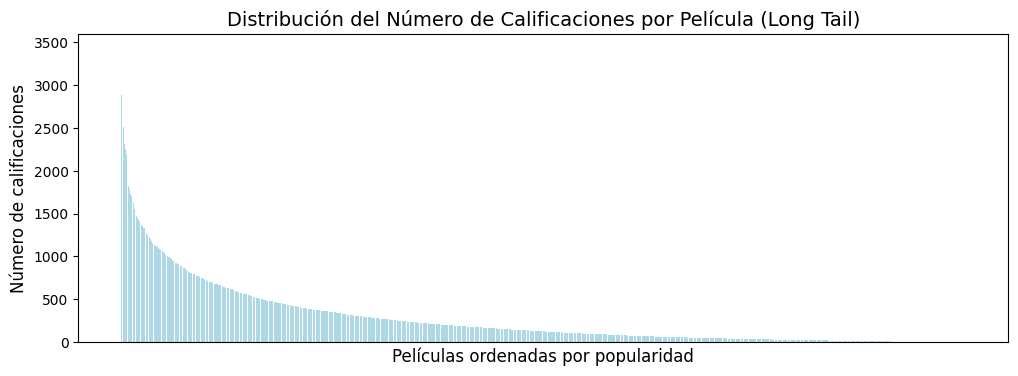

In [ ]:
# Contar cuántas veces ha sido calificada cada película
item_rating_counts = user_item_rating['title'].value_counts()

# Generar el gráfico de barras para visualizar el long tail
plt.figure(figsize=(12, 4))
plt.bar(range(len(item_rating_counts)), item_rating_counts, color='lightblue')
plt.title('Distribución del Número de Calificaciones por Película (Long Tail)', fontsize=14)
plt.xlabel('Películas ordenadas por popularidad', fontsize=12)
plt.ylabel('Número de calificaciones', fontsize=12)
plt.xticks([], [])
plt.show()


Observamos que pocas películas tienen muchas calificaciones, mientras que la mayoría tiene pocas.

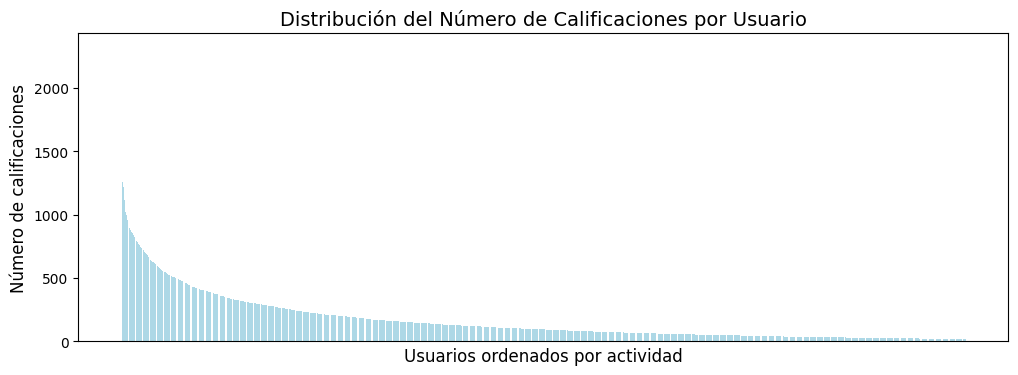

In [ ]:
# Contar cuántas calificaciones ha hecho cada usuario
user_rating_counts = user_item_rating['userId'].value_counts()

# Generar el gráfico de barras para visualizar el long tail
plt.figure(figsize=(12, 4))
plt.bar(range(len(user_rating_counts)), user_rating_counts, color='lightblue')
plt.title('Distribución del Número de Calificaciones por Usuario', fontsize=14)
plt.xlabel('Usuarios ordenados por actividad', fontsize=12)
plt.ylabel('Número de calificaciones', fontsize=12)
plt.xticks([], [])  # Oculta los ticks para no saturar el eje x
plt.show()


Se observa que la mayoría de los usuarios ha hecho relativamente pocas calificaciones y un numero pequeño de usuarios tiene un alto numero de calificaciones.

## 6. Filtrado de Datos


Para mejorar el análisis, filtramos las películas con pocas calificaciones.



### 6.1 Filtrado por Número Mínimo de Calificaciones


In [ ]:
# Establecer el mínimo de calificaciones por película
min_ratings_per_movie = 5

# Filtrar las películas con al menos min_ratings_per_movie calificaciones
movie_counts = user_item_rating['title'].value_counts()
popular_movies = movie_counts[movie_counts >= min_ratings_per_movie].index

# Filtrar el dataset original
filtered_data = user_item_rating[user_item_rating['title'].isin(popular_movies)]
filtered_data.head()


,userId,title,rating
0,1,One Flew Over the Cuckoo's Nest (1975),5
29,1,"Close Shave, A (1995)",3
30,1,Antz (1998),4
31,1,"Girl, Interrupted (1999)",4
32,1,Hercules (1997),4


### 6.2 Visualización Después del Filtrado


**Número de Películas Después del Filtrado**


In [ ]:
# Número de películas únicas después del filtrado
num_filtered_movies = filtered_data['title'].nunique()
print(f"Después del filtrado, hay {num_filtered_movies} películas.")


Después del filtrado, hay 3416 películas.


**Distribución Long Tail Después del Filtrado**

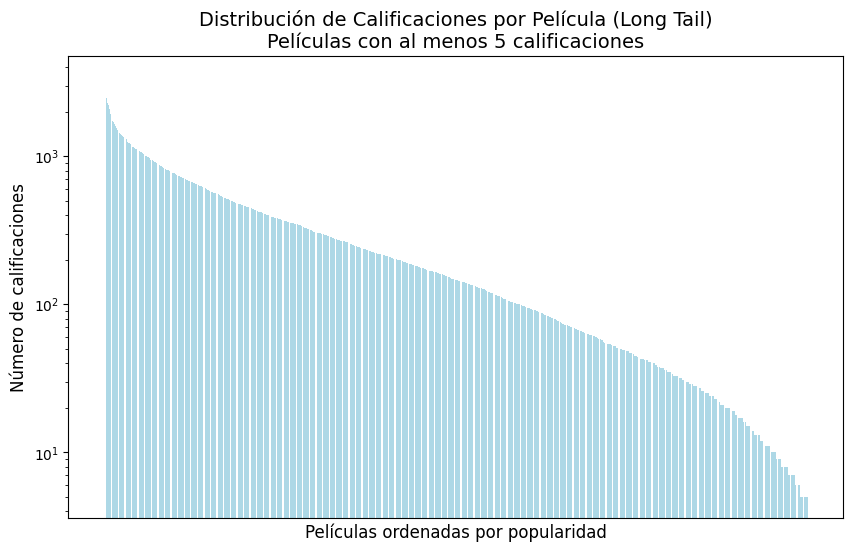

In [ ]:
# Contar calificaciones por película en datos filtrados
filtered_movie_rating_counts = filtered_data['title'].value_counts()

# Gráfico de barras para visualizar el long tail filtrado
plt.figure(figsize=(10, 6))
plt.bar(range(len(filtered_movie_rating_counts)), filtered_movie_rating_counts, color='lightblue')
plt.title(f'Distribución de Calificaciones por Película (Long Tail)\nPelículas con al menos {min_ratings_per_movie} calificaciones', fontsize=14)
plt.xlabel('Películas ordenadas por popularidad', fontsize=12)
plt.ylabel('Número de calificaciones', fontsize=12)
plt.yscale('log')
plt.xticks([], [])
plt.show()


** 7. Análisis de Usuarios Activos


Analizamos la actividad de los usuarios en el dataset filtrado.



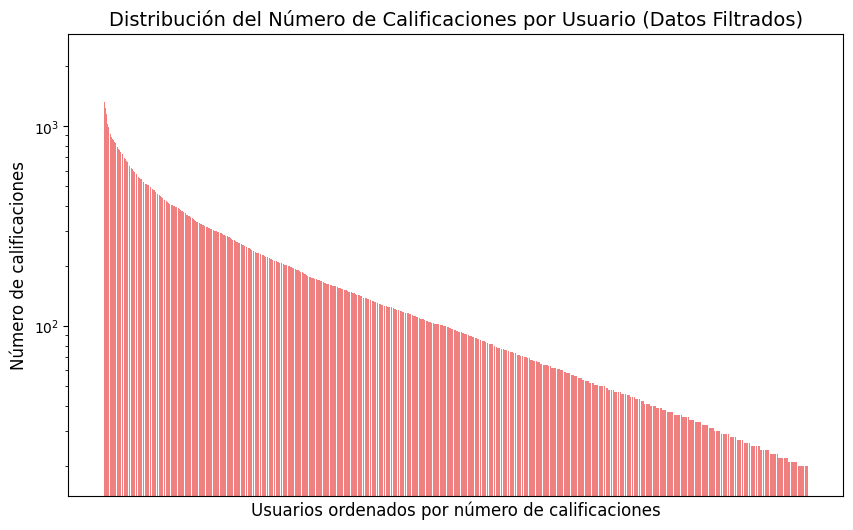

In [ ]:
# Contar cuántas películas ha calificado cada usuario
user_rating_counts_filtered = filtered_data['userId'].value_counts()

# Gráfico de barras para visualizar calificaciones por usuario
plt.figure(figsize=(10, 6))
plt.bar(range(len(user_rating_counts_filtered)), user_rating_counts_filtered, color='lightcoral')
plt.title('Distribución del Número de Calificaciones por Usuario (Datos Filtrados)', fontsize=14)
plt.xlabel('Usuarios ordenados por número de calificaciones', fontsize=12)
plt.ylabel('Número de calificaciones', fontsize=12)
plt.yscale('log')
plt.xticks([], [])
plt.show()


Usuarios altamente activos proporcionan más datos, mejoran la estabilidad y la diversidad del sistema, pero pueden sesgar las recomendaciones y reducir la personalización.

## 9. Enfoques de Filtrado Colaborativo

### 9.1. User-User Collaborative Filtering:
Este enfoque se basa en encontrar similitudes entre usuarios. La idea es que si dos usuarios tienen gustos similares, las películas que le gustaron a uno pueden ser recomendadas al otro.

Funcionamiento:

Calcula la similitud entre los usuarios según las películas que ambos han puntuado.
Recomendaciones basadas en lo que los usuarios similares han visto y puntuado positivamente.
Ventajas:

Fácil de entender y aplicar en sistemas con muchos usuarios y relativamente pocos ítems.
Captura bien las preferencias de los usuarios, especialmente cuando se dispone de suficientes datos de interacciones por usuario.
Desventajas:

Puede fallar en sistemas con muchos usuarios inactivos o nuevos usuarios (el problema de arranque en frío), ya que no hay suficientes datos para determinar las similitudes.
Si hay pocos usuarios con intereses similares a un usuario específico, el modelo puede tener dificultades para generar recomendaciones relevantes.



### 9.2. Item-Item Collaborative Filtering:
Este enfoque se basa en encontrar similitudes entre ítems. En lugar de comparar usuarios, compara las películas (u otros ítems) que han sido puntuadas de forma similar por los usuarios.

Funcionamiento:

Calcula la similitud entre ítems en función de los usuarios que los han puntuado.
Recomendaciones basadas en ítems similares a los que el usuario ha visto y puntuado positivamente.
Ventajas:

Escala mejor cuando el número de usuarios es mayor que el número de ítems, ya que los ítems tienden a ser más estáticos y estables en el tiempo.
Captura bien las relaciones entre ítems, lo que es útil cuando los usuarios han visto pocos ítems pero esos ítems tienen similitudes con otros (útil en el caso del arranque en frío para nuevos usuarios).
Desventajas:

Requiere una buena cantidad de datos de interacciones entre usuarios e ítems para poder calcular las similitudes entre ítems de manera efectiva.
Puede fallar cuando hay ítems muy únicos o de nicho, ya que estos no tendrán muchos puntos de comparación con otros ítems.

# Cuándo elegir cada enfoque:
1. User-User Collaborative Filtering:
Útil cuando tienes usuarios que han puntuado suficientes películas (o ítems) y hay patrones claros de comportamiento entre los usuarios.
Adecuado si deseas hacer recomendaciones personalizadas basadas en lo que otros usuarios con gustos similares han visto.
2. Item-Item Collaborative Filtering:
Más útil cuando tienes un número significativo de ítems y prefieres basar las recomendaciones en ítems que son similares entre sí.
Adecuado para casos donde los usuarios han puntuado menos ítems, pero quieres recomendar ítems basados en similitudes de características o preferencias generales.

## 10. Estrategias de División de Datos


Es importante cómo dividimos los datos en entrenamiento y prueba para evaluar el modelo adecuadamente.

Existen varias estrategias para dividir los datos entre train y test en sistemas de recomendación, y la forma en que se "enmascaran" las preferencias de los usuarios puede tener un impacto importante en la evaluación y el rendimiento del modelo. El enfoque más común es enmascarar (ocultar) preferencias al azar de todos los clientes, pero hay otras estrategias que también pueden ser útiles, dependiendo del objetivo del sistema y los datos disponibles.

### 10.1. Muestreo aleatorio (Random Holdout)
Este es el enfoque más común y se basa en seleccionar interacciones (calificaciones, visualizaciones, etc.) de manera aleatoria para enmascararlas y moverlas al conjunto de prueba (test), mientras que el resto de las interacciones se usan para entrenar el modelo.

Cómo funciona:

Para cada usuario, se selecciona un porcentaje de sus interacciones al azar (por ejemplo, el 25%) para el conjunto de prueba.
El modelo se entrena con el 75% restante y luego se evalúa prediciendo los valores en el 25% que se enmascaró.
Ventajas:

Es una técnica simple y funciona bien cuando las interacciones son suficientemente variadas y numerosas.
Se utiliza mucho en K-fold cross-validation, donde se repite el proceso varias veces para obtener una evaluación robusta del modelo.
Desventajas:

Si hay usuarios que tienen muy pocas interacciones, enmascarar al azar puede llevar a que estos usuarios no tengan suficientes datos para el entrenamiento.

### 10.2. Leave-N-Out (LNO)
En este enfoque, para cada usuario, se deja una cantidad fija de ítems (N) en el conjunto de prueba, mientras que el resto se usa para entrenar el modelo. Es una estrategia útil cuando quieres garantizar que todos los usuarios tengan al menos algunas interacciones en ambos conjuntos (train y test).

Cómo funciona:

Para cada usuario, se selecciona un número fijo de ítems (por ejemplo, N = 1 o N = 2) para el conjunto de prueba, y el resto se utiliza en el conjunto de entrenamiento.
El modelo se entrena en el resto de las interacciones y se evalúa en esas interacciones específicas que se dejaron fuera.
Ventajas:

Garantiza que todos los usuarios tengan al menos una interacción en el conjunto de entrenamiento.
Útil para evitar que ciertos usuarios queden completamente fuera del conjunto de entrenamiento.
Desventajas:

Si el número de interacciones por usuario es pequeño, este enfoque puede no ser adecuado, ya que dejar solo una o dos interacciones fuera no genera un conjunto de prueba suficientemente robusto.

### 10.3. Temporal Holdout (basado en tiempo)

En este enfoque, las interacciones más recientes de cada usuario se mueven al conjunto de prueba, mientras que las interacciones anteriores se utilizan para el entrenamiento. Este enfoque es útil en situaciones donde el tiempo es un factor importante y refleja cómo se usan los sistemas de recomendación en el mundo real (las recomendaciones se basan en el comportamiento pasado para predecir comportamientos futuros).

Cómo funciona:
Para cada usuario, las últimas interacciones cronológicas se colocan en el conjunto de prueba, mientras que las interacciones anteriores se utilizan en el conjunto de entrenamiento.
Ventajas:
Refleja el comportamiento real del usuario en el tiempo, lo que lo hace muy útil para sistemas de recomendación donde el contexto temporal es importante (ej. música, películas, compras).
Desventajas:
Puede haber un sesgo hacia los ítems más recientes y puede no ser adecuado si las interacciones no tienen un patrón temporal claro.

### 10.4. Cross-Validation (Validación Cruzada)
Este enfoque no enmascara preferencias al azar para un conjunto de prueba estático, sino que crea varios subconjuntos de prueba a partir de los datos de entrenamiento para realizar múltiples evaluaciones y obtener un performance más robusto.

Cómo funciona:

Los datos se dividen en varios subconjuntos (por ejemplo, 5), y el modelo se entrena en todos menos uno de estos subconjuntos. El subconjunto que queda fuera actúa como conjunto de prueba.
Este proceso se repite varias veces, cada vez con un subconjunto diferente como conjunto de prueba, y luego se promedian los resultados.
Ventajas:

Proporciona una evaluación más robusta del rendimiento, ya que evalúa el modelo en múltiples subconjuntos.
Desventajas:

Es computacionalmente más costoso, ya que implica entrenar y evaluar el modelo varias veces.


### 10.1 Muestreo Aleatorio (Random Holdout)



Dividimos las interacciones asegurando que cada usuario tenga al menos una interacción en el conjunto de entrenamiento.

In [ ]:
def Random_Holdout(df, test_size=0.25):
    """Divide los datos asegurando que cada usuario tenga al menos una interacción en el conjunto de entrenamiento"""
    # Seleccionar al azar un porcentaje de interacciones por usuario para entrenamiento
    train_df = df.groupby('userId').apply(lambda x: x.sample(frac=1 - test_size, random_state=42)).reset_index(drop=True)
    # El resto va al conjunto de prueba
    test_df = pd.concat([df, train_df]).drop_duplicates(keep=False)

    return train_df, test_df

# Aplicar la función al dataset filtrado
train_df, test_df = Random_Holdout(filtered_data, test_size=0.3)


<ipython-input-21-b971037283ec>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = df.groupby('userId').apply(lambda x: x.sample(frac=1 - test_size, random_state=42)).reset_index(drop=True)


### 10.2 Verificación de la División


Verificamos que la división se haya realizado correctamente.



In [ ]:
# Calificaciones del usuario 324 en entrenamiento
train_df[train_df.userId == 324].sort_values(by='rating', ascending=False).head()
train_df

,userId,title,rating
0,1,Saving Private Ryan (1998),5
1,1,Pleasantville (1998),3
2,1,Big (1988),4
3,1,Toy Story (1995),5
4,1,Airplane! (1980),4
...,...,...,...
699666,6040,Spartacus (1960),5
699667,6040,Batman (1989),2
699668,6040,"Man with Two Brains, The (1983)",1
699669,6040,Grand Hotel (1932),5


In [ ]:
# Calificaciones del usuario 324 en prueba
test_df[test_df.userId == 324].sort_values(by='rating', ascending=False).head()


,userId,title,rating
48258,324,"Matrix, The (1999)",5
48285,324,"Usual Suspects, The (1995)",5
48237,324,Star Trek: The Wrath of Khan (1982),5
48248,324,Tomorrow Never Dies (1997),4
48255,324,Star Wars: Episode I - The Phantom Menace (1999),4


## 11. Construcción del Modelo KNN


Utilizamos la librería surprise para implementar el modelo de filtrado colaborativo.



### 11.1 Preparación de Datos para Surprise

Convertimos los datos al formato requerido por la librería.

In [ ]:
from surprise import Dataset, Reader, KNNBasic, accuracy

# Definir el rango de calificaciones
reader = Reader(rating_scale=(1, 5))

# Cargar datos de entrenamiento
trainset = Dataset.load_from_df(train_df[['userId', 'title', 'rating']], reader).build_full_trainset()

# Crear conjunto de prueba
testset = list(test_df[['userId', 'title', 'rating']].itertuples(index=False, name=None))

### 11.2 Configuración y Entrenamiento del Modelo


Configuramos el modelo KNN y lo entrenamos con los datos de entrenamiento.



In [ ]:
# Configurar opciones del modelo KNN
sim_options = {
    'name': 'msd',  # Mean Squared Difference (distancia euclidiana)
    'user_based': True  # Filtrado Usuario-Usuario
}

# Crear el modelo KNN
knn = KNNBasic(k=50, sim_options=sim_options)

# Entrenar el modelo
knn.fit(trainset)


Computing the msd similarity matrix...
Done computing similarity matrix.


## 12. Evaluación del Modelo


Realizamos predicciones y evaluamos el rendimiento del modelo.



### 12.1 Cálculo del RMSE


In [ ]:
# Hacer predicciones sobre el conjunto de prueba
predictions = knn.test(testset)

# Calcular el RMSE
rmse = accuracy.rmse(predictions)
print(f"RMSE del modelo: {rmse:.4f}")


RMSE: 0.9270
RMSE del modelo: 0.9270


### 12.2 Ajuste de Hiperparámetros


Utilizamos Grid Search para encontrar el mejor valor de k.



In [ ]:
from surprise.model_selection import GridSearchCV

# Cargar el dataset completo para Grid Search
data = Dataset.load_from_df(filtered_data[['userId', 'title', 'rating']], reader)

# Definir la malla de parámetros
param_grid = {
    'k': [10, 20, 30, 40, 50],  # Valores de k a probar
    'sim_options': {
        'name': ['msd'],
        'user_based': [False]
    }
}

# Configurar Grid Search
grid_search = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3)

# Ejecutar Grid Search
grid_search.fit(data)

# Mostrar los mejores parámetros y RMSE
best_k = grid_search.best_params['rmse']['k']
best_rmse = grid_search.best_score['rmse']
print(f"Mejor k: {best_k}")
print(f"Mejor RMSE obtenido: {best_rmse:.4f}")


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

### 13. Análisis de Predicciones


Convertimos las predicciones a un DataFrame para su análisis detallado.



In [ ]:
# Convertir predicciones a DataFrame
predictions_df = pd.DataFrame(predictions, columns=['userId', 'movieId', 'real_rating', 'predicted_rating', 'details'])

# Mostrar las predicciones principales para el usuario 324
user_324_predictions = predictions_df[predictions_df.userId == 324].sort_values(by='predicted_rating', ascending=False)
user_324_predictions.head(10)


,userId,movieId,real_rating,predicted_rating,details
14464,324,"Matrix, The (1999)",5,3.574512,"{'actual_k': 50, 'was_impossible': False}"
14466,324,"Princess Bride, The (1987)",4,3.563279,"{'actual_k': 50, 'was_impossible': False}"
14459,324,In the Line of Fire (1993),3,3.558129,"{'actual_k': 50, 'was_impossible': False}"
14467,324,Aladdin (1992),4,3.556553,"{'actual_k': 50, 'was_impossible': False}"
14458,324,Remember the Titans (2000),3,3.555360,"{'actual_k': 50, 'was_impossible': False}"
14463,324,"Sound of Music, The (1965)",4,3.532142,"{'actual_k': 50, 'was_impossible': False}"
14475,324,"Green Mile, The (1999)",4,3.530491,"{'actual_k': 50, 'was_impossible': False}"
14462,324,"Usual Suspects, The (1995)",5,3.524539,"{'actual_k': 50, 'was_impossible': False}"
14453,324,GoldenEye (1995),4,3.523349,"{'actual_k': 50, 'was_impossible': False}"
14474,324,Enemy of the State (1998),3,3.521239,"{'actual_k': 50, 'was_impossible': False}"


In [ ]:
predictions_df['movieId'].unique()


array(['Antz (1998)', 'Hunchback of Notre Dame, The (1996)',
       'Sixth Sense, The (1999)', ...,
       'Message to Love: The Isle of Wight Festival (1996)',
       'Last September, The (1999)', 'Alarmist, The (1997)'], dtype=object)

El campo details indica cuántos vecinos se utilizaron realmente para hacer la predicción.



## 14. Evaluación de Recomendaciones


Evaluamos la calidad de las recomendaciones utilizando métricas específicas.



### 14.1 Hit Rate Global

Calculamos la tasa de aciertos global en las recomendaciones.

In [ ]:
# Definir umbral de relevancia
relevant_threshold = 4.0

# Inicializar contadores
hits = 0
total_relevant = 0

# Iterar sobre todas las predicciones
for _, row in predictions_df.iterrows():
    real_rating = row['real_rating']
    predicted_rating = row['predicted_rating']

    # Considerar películas con calificación real ≥ umbral como relevantes
    if real_rating >= relevant_threshold:
        total_relevant += 1
        # Si la predicción también es ≥ umbral, es un acierto
        if predicted_rating >= relevant_threshold:
            hits += 1

# Calcular el Hit Rate Global
hit_rate_global = hits / total_relevant if total_relevant > 0 else 0
print(f"Hit Rate Global: {hit_rate_global:.2f}")



Hit Rate Global: 0.46


###14.2 Hit Rate por Usuario

Calculamos la tasa de aciertos promedio por usuario.

In [ ]:
# Inicializar lista para almacenar hit rates por usuario
hit_rates = []

# Agrupar predicciones por usuario
for user_id, group in predictions_df.groupby('userId'):
    hits = 0
    total_relevant = 0

    for _, row in group.iterrows():
        real_rating = row['real_rating']
        predicted_rating = row['predicted_rating']

        # Considerar películas relevantes
        if real_rating >= relevant_threshold:
            total_relevant += 1
            if predicted_rating >= relevant_threshold:
                hits += 1

    # Calcular Hit Rate para el usuario
    if total_relevant > 0:
        hit_rate_user = hits / total_relevant
        hit_rates.append(hit_rate_user)

# Calcular el Hit Rate promedio
hit_rate_avg_user = sum(hit_rates) / len(hit_rates) if len(hit_rates) > 0 else 0
print(f"Hit Rate promedio por usuario: {hit_rate_avg_user:.2f}")


Hit Rate promedio por usuario: 0.48


## 15. Análisis de Diversidad
Evaluamos la diversidad de las recomendaciones generadas por el modelo.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Obtener películas recomendadas para cada usuario
recommendations_by_user = predictions_df.groupby('userId')['movieId'].apply(list)

# Crear matriz usuario-ítem de recomendaciones
user_item_matrix = pd.DataFrame(0, index=recommendations_by_user.index, columns=movies['movieId'])

# Llenar la matriz con las recomendaciones
for user, movies_recommended in recommendations_by_user.items():
    user_item_matrix.loc[user, movies_recommended] = 1

# Reemplazar NaN por 0
user_item_matrix.fillna(0, inplace=True)

# Calcular similitud entre usuarios
similarity_matrix = cosine_similarity(user_item_matrix)

# La diversidad es 1 - similitud
diversity_matrix = 1 - similarity_matrix

# Calcular diversidad promedio (excluyendo la diagonal)
average_diversity = np.mean(diversity_matrix[np.triu_indices_from(diversity_matrix, k=1)])
print(f"Diversidad promedio de las recomendaciones: {average_diversity:.2f}")


## 16. Conclusiones

En este laboratorio:

- Exploramos y visualizamos el dataset MovieLens, observando la distribución Long Tail y cómo afecta a las calificaciones.
- Filtramos los datos para enfocarnos en películas populares y usuarios activos, mejorando así la calidad del modelo.
- Implementamos un modelo de Filtrado Colaborativo Usuario-Usuario utilizando KNN, ajustando el número de vecinos para optimizar el rendimiento.
- Evaluamos el modelo utilizando métricas como RMSE y Hit Rate, obteniendo insights sobre su precisión y capacidad de recomendación.
- Analizamos la diversidad de las recomendaciones, entendiendo cómo el modelo equilibra la similitud y la variedad en sus sugerencias.

Este proceso demuestra cómo aplicar filtrado colaborativo en sistemas de recomendación y resalta consideraciones importantes como la esparsidad de datos, la actividad del usuario y las métricas de evaluación.

----

Nota: Para mejorar aún más el sistema de recomendación, se pueden explorar enfoques híbridos, incorporar información contextual o utilizar técnicas avanzadas como modelos basados en aprendizaje profundo.


# 17. Desafío: Implementación de Filtrado Colaborativo Item-Item


Hasta ahora, hemos utilizado un enfoque de Filtrado Colaborativo basado en Usuarios (User-User), donde las recomendaciones se generan comparando usuarios entre sí. En este desafío, vas a implementar el enfoque de Filtrado Colaborativo basado en Ítems (Item-Item).

En lugar de buscar usuarios similares para hacer recomendaciones, el sistema buscará ítems similares (películas, en este caso). Si a un usuario le gusta una película, se le recomendarán otras películas similares a esa, basadas en cómo otros usuarios han calificado ambas películas.

### 17.0. Creación de la Matriz Ítem-Usuario


Construimos una matriz donde las filas son Peliculas y las columnas son Usuarios.



In [ ]:
# Crear la matriz ítem-usuario
item_user_matrix = filtered_data.pivot_table(index='title', columns='userId', values='rating')

# Ordenar los ítems por cantidad de calificaciones recibidas (opcional, útil para ciertas optimizaciones)
item_counts = filtered_data['title'].value_counts()
sorted_item_ids = item_counts.index

# Ordenar la matriz según ítems más calificados
item_user_matrix_sorted = item_user_matrix.loc[sorted_item_ids]
item_user_matrix_sorted.head()

userId,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
title,,,,,,,,,,,,,,,,,,,,,
American Beauty (1999),NaN,4.0,4.0,NaN,4.0,1.0,NaN,5.0,4.0,3.0,...,NaN,NaN,NaN,NaN,NaN,5.0,4.0,NaN,NaN,4.0
Star Wars: Episode IV - A New Hope (1977),4.0,NaN,5.0,5.0,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,4.0,NaN,NaN,5.0,5.0,NaN,5.0,4.0
Star Wars: Episode V - The Empire Strikes Back (1980),NaN,5.0,4.0,2.0,NaN,NaN,5.0,NaN,NaN,5.0,...,NaN,4.0,4.0,NaN,5.0,5.0,NaN,NaN,NaN,3.0
Star Wars: Episode VI - Return of the Jedi (1983),NaN,4.0,4.0,3.0,NaN,3.0,NaN,4.0,4.0,4.0,...,5.0,NaN,4.0,NaN,5.0,3.0,4.0,4.0,5.0,2.0
Jurassic Park (1993),NaN,5.0,4.0,4.0,NaN,NaN,4.0,5.0,4.0,4.0,...,NaN,NaN,5.0,NaN,2.0,3.0,NaN,NaN,NaN,NaN


### 17.1 Configuración y Entrenamiento del Modelo




In [ ]:
# Configurar opciones del modelo KNN para filtrado basado en ítems
sim_options = {
    'name': 'msd',  # Mean Squared Difference (distancia euclidiana)
    'user_based': False  # Filtrado Ítem-Ítem
}

# Crear el modelo KNN
knn = KNNBasic(k=50, sim_options=sim_options)

# Entrenar el modelo
knn.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


### 17.2 Configuración y Entrenamiento del Modelo


   17.2.1 Cálculo del RMSE


In [ ]:
# Hacer predicciones sobre el conjunto de prueba
predictions = knn.test(testset)

# Calcular el RMSE
rmse = accuracy.rmse(predictions)
print(f"RMSE del modelo: {rmse:.4f}")

RMSE: 0.9252
RMSE del modelo: 0.9252


### 17.3 Evaluación de Recomendaciones


17.3.1 Hit Rate Global


In [ ]:
# Definir umbral de relevancia
relevant_threshold = 4.0

# Inicializar contadores
hits = 0
total_relevant = 0

# Iterar sobre todas las predicciones
for _, row in predictions_df.iterrows():
    real_rating = row['real_rating']
    predicted_rating = row['predicted_rating']

    # Considerar películas con calificación real ≥ umbral como relevantes
    if real_rating >= relevant_threshold:
        total_relevant += 1
        # Si la predicción también es ≥ umbral, es un acierto
        if predicted_rating >= relevant_threshold:
            hits += 1

# Calcular el Hit Rate Global
hit_rate_global = hits / total_relevant if total_relevant > 0 else 0
print(f"Hit Rate Global: {hit_rate_global:.2f}")



Hit Rate Global: 0.46


17.3.2 Hit Rate por Item


In [ ]:
# Inicializar lista para almacenar hit rates por ítem
hit_rates = []

# Agrupar predicciones por ítem (suponiendo que 'itemId' es el identificador del ítem)
for movieId, group in predictions_df.groupby('movieId'):
    hits = 0
    total_relevant = 0

    # Iterar sobre cada fila en el grupo de ítems
    for _, row in group.iterrows():
        real_rating = row['real_rating']
        predicted_rating = row['predicted_rating']

        # Considerar los usuarios que realmente encuentran este ítem relevante
        if real_rating >= relevant_threshold:
            total_relevant += 1
            # Verificar si la predicción también alcanza el umbral de relevancia
            if predicted_rating >= relevant_threshold:
                hits += 1

    # Calcular Hit Rate para el ítem
    if total_relevant > 0:
        hit_rate_item = hits / total_relevant
        hit_rates.append(hit_rate_item)

# Calcular el Hit Rate promedio por ítem
hit_rate_avg_item = sum(hit_rates) / len(hit_rates) if len(hit_rates) > 0 else 0
print(f"Hit Rate promedio por ítem: {hit_rate_avg_item:.2f}")

Hit Rate promedio por ítem: 0.18


El Hit Rate Global de 0.46 muestra que casi la mitad de las recomendaciones son relevantes para los usuarios, indicando un rendimiento aceptable del sistema. Sin embargo, el Hit Rate promedio por ítem de 0.18 revela que muchos ítems individualmente no son frecuentemente relevantes

### 17.4 Analisis de Predicciones

In [ ]:
# Convertir predicciones a DataFrame
predictions_df = pd.DataFrame(predictions, columns=['userId', 'movieId', 'real_rating', 'predicted_rating', 'details'])

# ID de la película que te interesa
movie_name_interested = 'Antz (1998)'  # Cambia este número por el ID real de la película que quieres analizar

# Filtrar las predicciones para esa película específica
movie_predictions = predictions_df[predictions_df.movieId == movie_name_interested].sort_values(by='predicted_rating', ascending=False)

# Mostrar las predicciones principales para esa película
movie_predictions.head(10)


,userId,movieId,real_rating,predicted_rating,details
204835,4086,Antz (1998),5,4.595413,"{'actual_k': 50, 'was_impossible': False}"
62300,1271,Antz (1998),4,4.588522,"{'actual_k': 50, 'was_impossible': False}"
32788,714,Antz (1998),4,4.458897,"{'actual_k': 50, 'was_impossible': False}"
91172,1806,Antz (1998),4,4.437880,"{'actual_k': 50, 'was_impossible': False}"
280590,5645,Antz (1998),5,4.437353,"{'actual_k': 50, 'was_impossible': False}"
224231,4461,Antz (1998),4,4.395468,"{'actual_k': 50, 'was_impossible': False}"
254488,5100,Antz (1998),5,4.347008,"{'actual_k': 50, 'was_impossible': False}"
273339,5512,Antz (1998),3,4.326054,"{'actual_k': 50, 'was_impossible': False}"
18461,413,Antz (1998),4,4.316956,"{'actual_k': 50, 'was_impossible': False}"
73542,1481,Antz (1998),4,4.292284,"{'actual_k': 50, 'was_impossible': False}"


Para esta pelicula 'Antz (1998)' los resultados de la tabla muestran aparentemente predicciones cercanas a las calificaciones reales, sin embargo se notan diferencias con las calificaciones de 3 y 5 puntos.

In [ ]:
# Convertir predicciones a DataFrame
predictions_df = pd.DataFrame(predictions, columns=['userId', 'movieId', 'real_rating', 'predicted_rating', 'details'])

# ID de la película que te interesa
movie_name_interested = 'In the Bleak Midwinter (1995)'  # Cambia este número por el ID real de la película que quieres analizar

# Filtrar las predicciones para esa película específica
movie_predictions = predictions_df[predictions_df.movieId == movie_name_interested].sort_values(by='predicted_rating', ascending=False)

# Mostrar las predicciones principales para esa película
movie_predictions.head(10)


,userId,movieId,real_rating,predicted_rating,details
185835,3755,In the Bleak Midwinter (1995),4,4.439139,"{'actual_k': 48, 'was_impossible': False}"
270711,5458,In the Bleak Midwinter (1995),3,4.089981,"{'actual_k': 50, 'was_impossible': False}"
82795,1671,In the Bleak Midwinter (1995),5,3.940000,"{'actual_k': 50, 'was_impossible': False}"
104321,2041,In the Bleak Midwinter (1995),4,3.664756,"{'actual_k': 50, 'was_impossible': False}"


En esta película se hacen más notorias las dificultades para predecir con precisión las calificaciones, bien podria ser por que es una películas menos conocida y que cuentan con menos datos de usuario disponibles.

### 17.5 Ajuste de Hiperparametros


In [ ]:
from surprise.model_selection import GridSearchCV

# Cargar el dataset completo para Grid Search
data = Dataset.load_from_df(filtered_data[['userId', 'title', 'rating']], reader)

# Definir la malla de parámetros
param_grid = {
    'k': [10, 20, 30, 40, 50],  # Valores de k a probar
    'sim_options': {
        'name': ['msd'],
        'user_based': [False]
    }
}

# Configurar Grid Search
grid_search = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3)

# Ejecutar Grid Search
grid_search.fit(data)

# Mostrar los mejores parámetros y RMSE
best_k = grid_search.best_params['rmse']['k']
best_rmse = grid_search.best_score['rmse']
print(f"Mejor k: {best_k}")
print(f"Mejor RMSE obtenido: {best_rmse:.4f}")


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

### 17.6 Evaluación de Recomendaciones despues del ajuste de hiperparametros


17.6.1 Hit Rate Global


In [ ]:
# Definir umbral de relevancia
relevant_threshold = 4.0

# Inicializar contadores
hits = 0
total_relevant = 0

# Iterar sobre todas las predicciones
for _, row in predictions_df.iterrows():
    real_rating = row['real_rating']
    predicted_rating = row['predicted_rating']

    # Considerar películas con calificación real ≥ umbral como relevantes
    if real_rating >= relevant_threshold:
        total_relevant += 1
        # Si la predicción también es ≥ umbral, es un acierto
        if predicted_rating >= relevant_threshold:
            hits += 1

# Calcular el Hit Rate Global
hit_rate_global = hits / total_relevant if total_relevant > 0 else 0
print(f"Hit Rate Global: {hit_rate_global:.2f}")



Hit Rate Global: 0.40


17.6.2 Hit Rate por Item


In [ ]:
# Inicializar lista para almacenar hit rates por ítem
hit_rates = []

# Agrupar predicciones por ítem (suponiendo que 'itemId' es el identificador del ítem)
for movieId, group in predictions_df.groupby('movieId'):
    hits = 0
    total_relevant = 0

    # Iterar sobre cada fila en el grupo de ítems
    for _, row in group.iterrows():
        real_rating = row['real_rating']
        predicted_rating = row['predicted_rating']

        # Considerar los usuarios que realmente encuentran este ítem relevante
        if real_rating >= relevant_threshold:
            total_relevant += 1
            # Verificar si la predicción también alcanza el umbral de relevancia
            if predicted_rating >= relevant_threshold:
                hits += 1

    # Calcular Hit Rate para el ítem
    if total_relevant > 0:
        hit_rate_item = hits / total_relevant
        hit_rates.append(hit_rate_item)

# Calcular el Hit Rate promedio por ítem
hit_rate_avg_item = sum(hit_rates) / len(hit_rates) if len(hit_rates) > 0 else 0
print(f"Hit Rate promedio por ítem: {hit_rate_avg_item:.2f}")

Hit Rate promedio por ítem: 0.25


El Hit Rate Global disminuyo a 0.40 lo que indica que la proporción de usuarios que encuentran al menos una recomendación relevante entre todas las proporcionadas ha disminuido. Sin embargo, el Hit Rate promedio por ítem a aumentado a 0.25 lo que significa que ahora un mayor porcentaje de las peliculas recomendadas es considerada relevante por los usuarios.

---
## Gracias por completar este laboratorio!